# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [9]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [4]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

'What does each column mean?\n\nAttribute Information:\n\n1) FRESH: annual spending (m.u.) on fresh products (Continuous);\n2) MILK: annual spending (m.u.) on milk products (Continuous);\n3) GROCERY: annual spending (m.u.)on grocery products (Continuous);\n4) FROZEN: annual spending (m.u.)on frozen products (Continuous)\n5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)\n6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);\n7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)\n8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)\n\nAny categorical data to convert? no, all already ints\n\nMissing data: no\n\nColumn collinearity - any high correlations? yes, eventually remove Grocery column\n\nDescriptive statistics - any outliers to remove?\n\n'

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


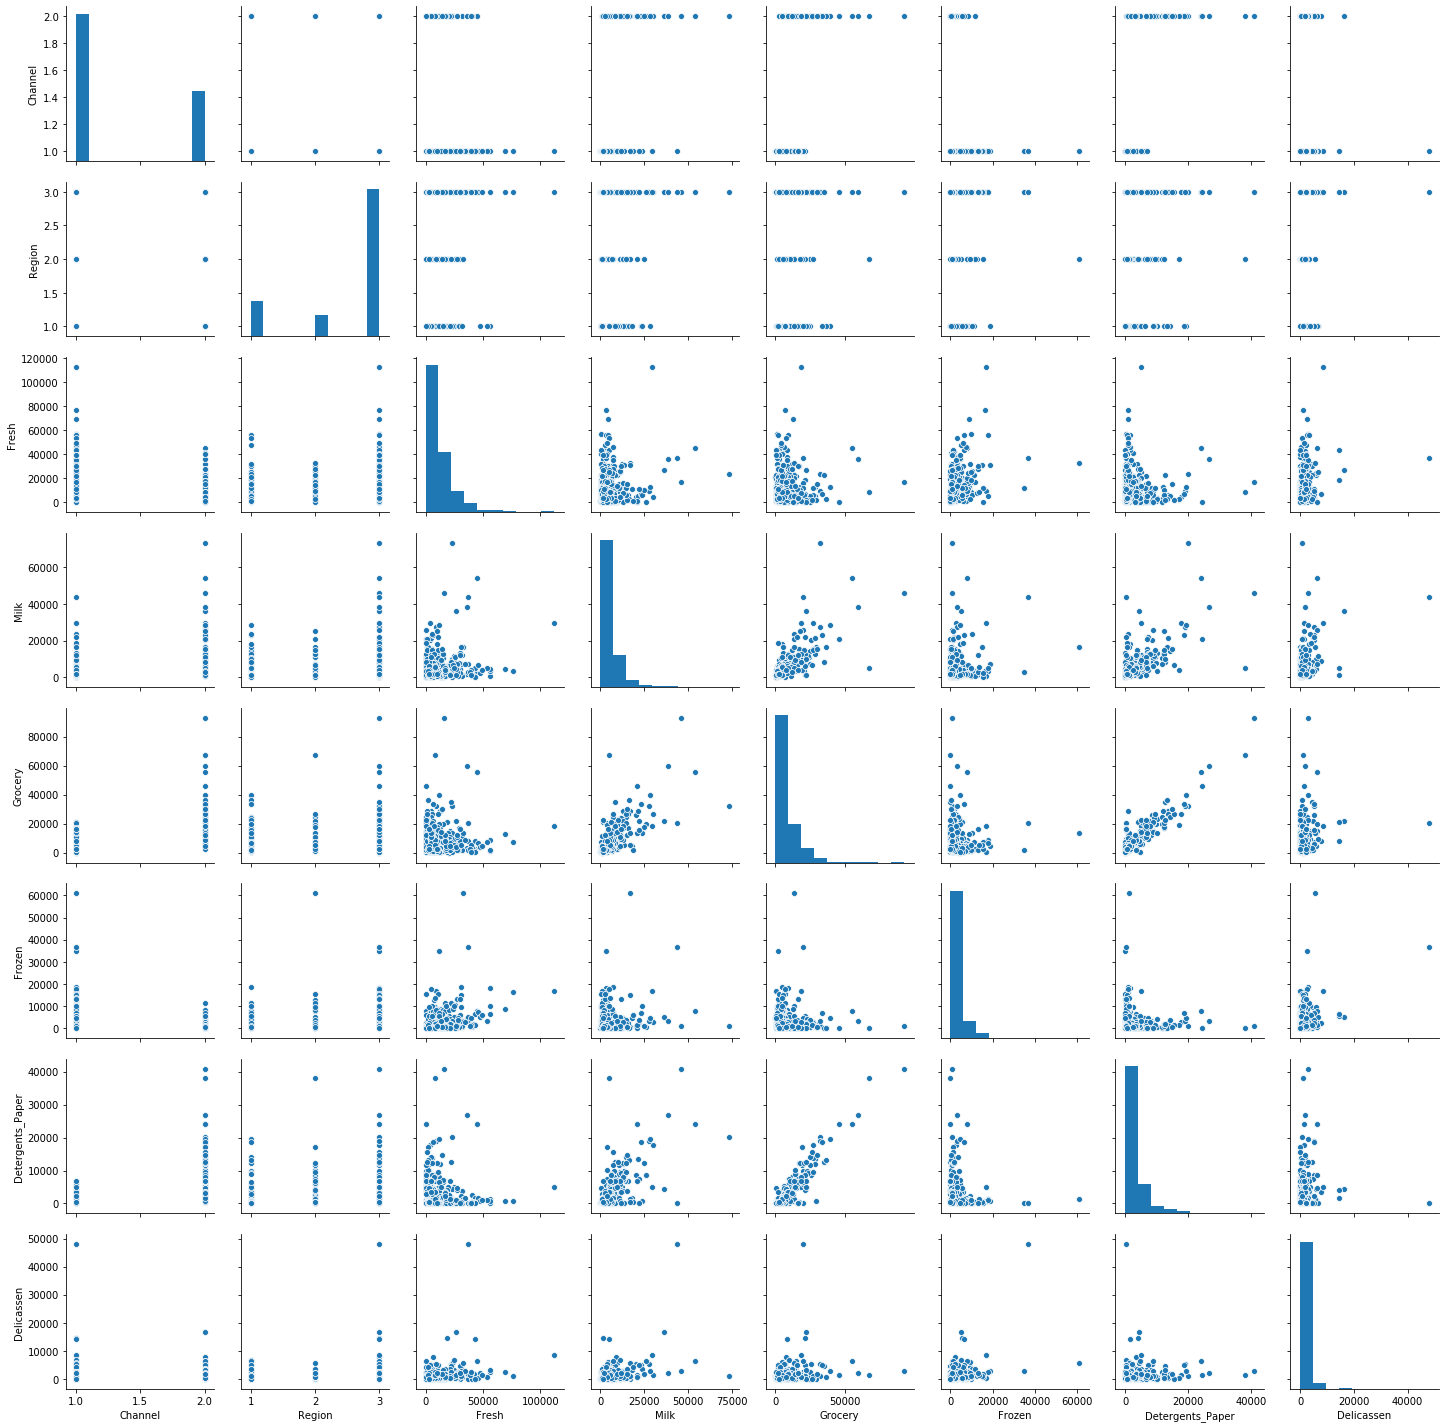

In [11]:
# Your code here:
"""

- What does each column mean?

Attribute Information:

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)

- Any categorical data to convert? no, all already ints

- Any missing data to remove?: no

- Column collinearity - any high correlations? yes, eventually remove Grocery column

- Descriptive statistics - any outliers to remove? Delicatessen?

- Column-wise data distribution - is the distribution skewed? Right skewed - higher frequency in low level

"""

customers.dtypes

customers.isna().sum()

customers.corr()

customers.describe()

sns.pairplot(customers)


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,214,2674,1338
1,2,3,7057,9810,1762,3293,1776
2,2,3,6353,8808,2405,3516,7844
3,1,3,13265,1196,6404,507,1788
4,2,3,22615,5410,3915,1777,5185


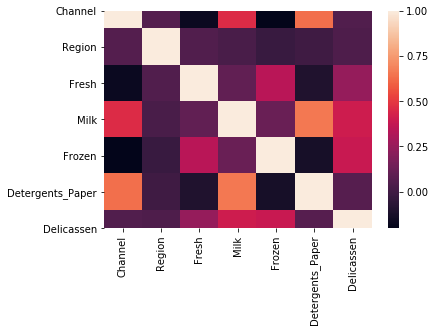

In [23]:
# Your code here
#customers_dropped = customers.drop(['Grocery'], axis=1)
customers_dropped.head()
customers_dropped_corr = customers_dropped.corr()
sns.heatmap(customers_dropped_corr)

In [ ]:
# Your comment here
"""
Highly correlated variables can be problematic in clustering:
When variables used in clustering are collinear, some variables get a higher weight than others. 
If two variables are perfectly correlated, they effectively represent the same concept. 
But that concept is now represented twice in the data and hence gets twice the weight of all the other variables. 
The final solution is likely to be skewed in the direction of that concept.
Therefore the variable "Grocery" will be removed, since this variable exhibit correlation with some other variables.

"""

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [36]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
customers_scale = pd.DataFrame(scaler.fit_transform(customers_dropped), columns = customers_dropped.columns)

# Check if mean close to 0 and std 1
customers_scale.mean(axis = 0)
customers_scale.std(axis = 0)


Channel            -2.452584e-16
Region             -5.737834e-16
Fresh              -2.422305e-17
Milk               -1.589638e-17
Frozen              1.135455e-17
Detergents_Paper   -1.917658e-17
Delicassen         -8.276208e-17
dtype: float64

Channel             1.001138
Region              1.001138
Fresh               1.001138
Milk                1.001138
Frozen              1.001138
Detergents_Paper    1.001138
Delicassen          1.001138
dtype: float64

In [37]:
customers_scale.describe()

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,4.400000e+02,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02
mean,1.614870e-17,3.552714e-16,-3.431598e-17,0.000000,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00
min,-6.902971e-01,-1.995342e+00,-9.496831e-01,-0.778795,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-6.902971e-01,-7.023369e-01,-7.023339e-01,-0.578306,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-6.902971e-01,5.906683e-01,-2.767602e-01,-0.294258,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,1.448652e+00,5.906683e-01,3.905226e-01,0.189092,9.946441e-02,2.184822e-01,1.048598e-01
max,1.448652e+00,5.906683e-01,7.927738e+00,9.183650,1.191900e+01,7.967672e+00,1.647845e+01


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [100]:
# Your code here:
from sklearn.cluster import KMeans

# Create k-mean object
cluster = KMeans(n_clusters=3,random_state=0)#, n_jobs=-1)

# Train model
model = cluster.fit(customers_scale)
customers_scale['labels'] = model.labels_

In [101]:
customers_scale.head()

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,1.448652,0.590668,0.052933,0.523568,-0.589367,-0.043569,-0.066339,1,0
1,1.448652,0.590668,-0.391302,0.544458,-0.270136,0.086407,0.089151,1,0
2,1.448652,0.590668,-0.447029,0.408538,-0.137536,0.133232,2.243293,1,-1
3,-0.690297,0.590668,0.100111,-0.624020,0.687144,-0.498588,0.093411,0,2
4,1.448652,0.590668,0.840239,-0.052396,0.173859,-0.231918,1.299347,1,-1


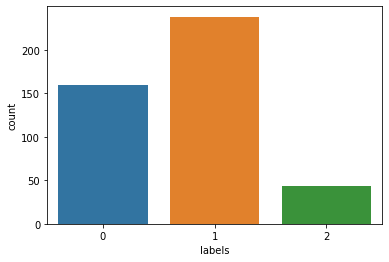

In [105]:
sns.countplot(customers_scale['labels'])

Count the values in `labels`.

In [106]:
customers_scale['labels'].count()

440

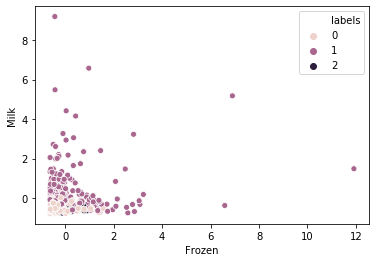

In [107]:
sns.scatterplot(x='Frozen',y='Milk',hue='labels', data=customers_scale)

In [88]:
# Your code here:
customers_scale['labels'].count()

440

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [75]:
# Your code here
# Load libraries

from sklearn.cluster import DBSCAN

# Create meanshift object
cluster = DBSCAN(eps=0.5)

# Train model
model = cluster.fit(customers_scale)

# Show cluster membership
customers_scale['labels_DBSCAN'] = model.labels_

Count the values in `labels_DBSCAN`.

In [76]:
# Your code here
customers_scale['labels_DBSCAN'].count()

440

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

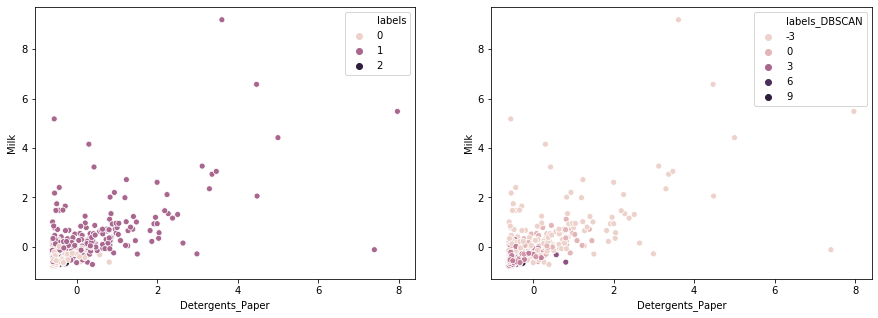

In [108]:
# Your code here:
f, axes = plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(  y="Milk", x= "Detergents_Paper", hue='labels', data=customers_scale,  ax=axes[0])
sns.scatterplot(  y="Milk", x= "Detergents_Paper", hue='labels_DBSCAN', data=customers_scale, ax=axes[1])



Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

'I dropped Grocery so will use Milk instead'

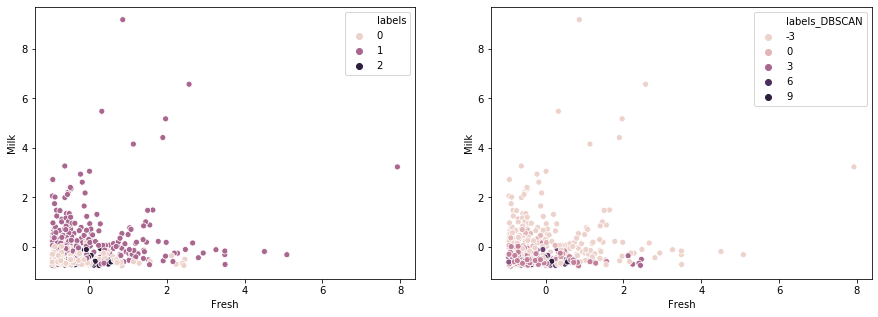

In [109]:
# Your code here:
"""I dropped Grocery so will use Milk instead"""
f, axes = plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(  y="Milk", x= "Fresh", hue='labels', data=customers_scale,  ax=axes[0])
sns.scatterplot(  y="Milk", x= "Fresh", hue='labels_DBSCAN', data=customers_scale, ax=axes[1])


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

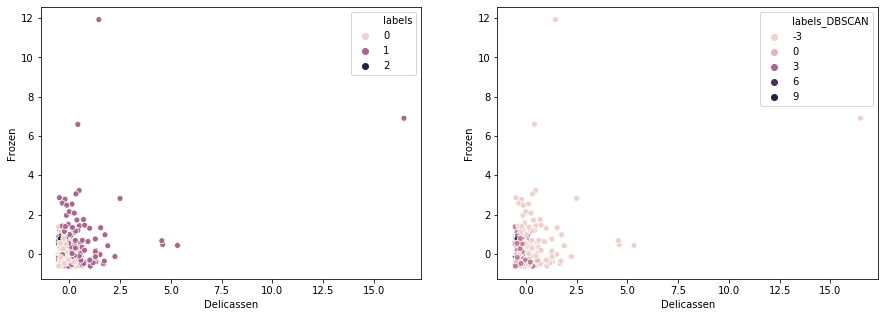

In [110]:
# Your code here:
# Your code here:
f, axes = plt.subplots(1,2, figsize=(15,5))

sns.scatterplot(  y="Frozen", x= "Delicassen", hue='labels', data=customers_scale,  ax=axes[0])
sns.scatterplot(  y="Frozen", x= "Delicassen", hue='labels_DBSCAN', data=customers_scale, ax=axes[1])


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [111]:
# Your code here:
customers_scale.groupby('labels').agg('mean')

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,
0,-0.555772,0.590668,-0.169121,-0.494116,-0.216034,-0.431775,-0.284265,2.025157
1,0.496011,-0.110162,0.141971,0.429351,0.163276,0.382480,0.241246,-0.852941
2,-0.690297,-1.574364,-0.160437,-0.549325,-0.104890,-0.520421,-0.284152,5.790698


In [112]:
customers_scale.groupby('labels_DBSCAN').agg('mean')

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,
-1,0.331762,-0.230995,0.274695,0.446682,0.270660,0.362225,0.288906,1
0,1.448652,0.590668,-0.627829,0.328827,-0.459554,0.499959,-0.035180,1
1,1.448652,0.590668,0.085354,-0.316311,-0.470466,0.079508,-0.429352,0
2,-0.690297,0.590668,-0.252163,-0.500172,-0.191390,-0.473716,-0.275052,0
3,-0.690297,0.590668,2.330913,-0.593472,-0.370277,-0.517654,-0.262725,0
4,1.448652,0.590668,-0.943588,-0.452741,-0.548192,0.531557,-0.423824,0
5,-0.690297,-1.995342,-0.164813,-0.546246,-0.303392,-0.532568,-0.303387,2
6,-0.690297,-1.995342,-0.409825,-0.522690,0.764752,-0.523890,-0.323478,2
7,-0.690297,-0.702337,-0.046365,-0.565798,-0.151485,-0.498978,-0.235700,2


Which algorithm appears to perform better?

In [ ]:
# Your observations here
# not sure, how do I know?

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here